# Dependencies

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import glob, os, random

# Load the Dataset

In [2]:
path = '/kaggle/input/sampah/GarbageNew/Garbage classification/Garbage classification'
img = glob.glob(os.path.join(path, '*/*.jpg'))

print(len(img))

3131


# Load Pre-trained model (Using Mobilenet v2) - Transfer Learning

In [3]:
module = ('mobilenet_v2', 224, 1280)
handle_base, pixels, FV_SIZE = module
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
img_size = (pixels, pixels)
print("USING {} with input size {} and output dimension {}".format(MODULE_HANDLE, img_size, FV_SIZE))

USING https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


Fine tuning the model

In [4]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=img_size + (3, ),
                                   output_shape=[FV_SIZE],
                                   trainable=True)

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rotation_range=40,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    path,
    target_size=img_size,
    batch_size=25,
    class_mode='categorical',
    subset='training',
    seed=0
)

val_generator = test_datagen.flow_from_directory(
    path,
    target_size=img_size,
    batch_size=25,
    class_mode='categorical',
    subset='validation',
    seed=0
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)
print(len(labels))

Found 3139 images belonging to 8 classes.
Found 312 images belonging to 8 classes.
{0: 'B3', 1: 'cardboard', 2: 'glass', 3: 'metal', 4: 'organic', 5: 'paper', 6: 'plastic', 7: 'trash'}
8


# Building the model

In [6]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 2587976 (9.87 MB)
Trainable params: 2553864 (9.74 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Training the model

In [8]:
history = model.fit(train_generator, epochs=50,
                    steps_per_epoch=30,
                    validation_data=val_generator)

model.save('model.h5')

Epoch 1/50
30/30 [==============================] - 103s 3s/step - loss: 1.6823 - accuracy: 0.6067 - val_loss: 2.4310 - val_accuracy: 0.6122
Epoch 2/50
30/30 [==============================] - 81s 3s/step - loss: 1.4541 - accuracy: 0.6576 - val_loss: 1.8334 - val_accuracy: 0.6699
Epoch 3/50
30/30 [==============================] - 81s 3s/step - loss: 1.2792 - accuracy: 0.7240 - val_loss: 2.4942 - val_accuracy: 0.6122
Epoch 4/50
30/30 [==============================] - 82s 3s/step - loss: 1.2543 - accuracy: 0.7587 - val_loss: 2.9912 - val_accuracy: 0.5673
Epoch 5/50
30/30 [==============================] - 79s 3s/step - loss: 1.1455 - accuracy: 0.7618 - val_loss: 2.5060 - val_accuracy: 0.5962
Epoch 6/50
30/30 [==============================] - 80s 3s/step - loss: 1.1917 - accuracy: 0.7507 - val_loss: 5.3010 - val_accuracy: 0.2596
Epoch 7/50
30/30 [==============================] - 81s 3s/step - loss: 1.1625 - accuracy: 0.7373 - val_loss: 1.5069 - val_accuracy: 0.7308
Epoch 8/50
30/30 [=

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Graph

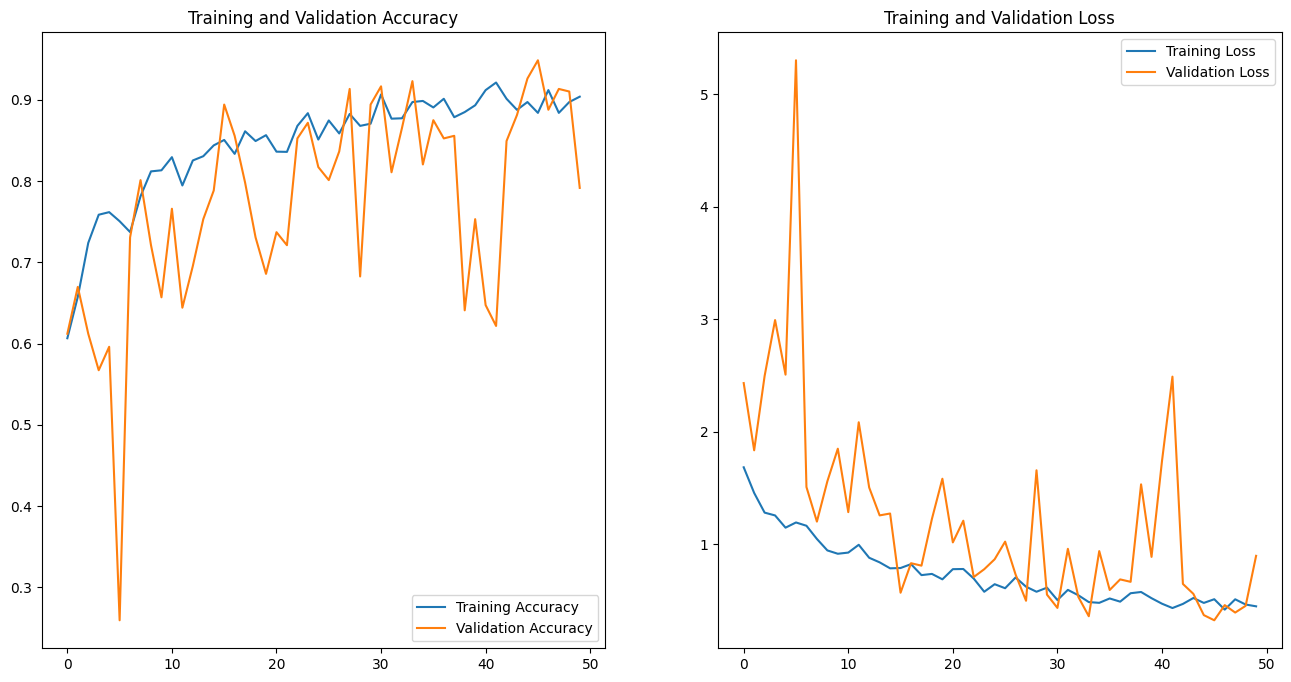

In [9]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs_range   = range(len(acc))
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [10]:
eval = model.evaluate(train_generator, return_dict=True, verbose=0)

print(eval)


{'loss': 0.7686403393745422, 'accuracy': 0.8219178318977356}
